#  e-CHURN XGBoost

### Material de referência.
xgboos: https://gist.github.com/pb111/cc341409081dffa5e9eaf60d79562a03
shap: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
lime: https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions#lime_tabular


### Etapas:
- Carga de bibliotecas e bases
- Preparação de dados
- Roda modelo simples
- Faz validação cruzada
- Pega aprendizados de modelo e variáveis e aplica modelo otimizado

## Carga de bibliotecas e bases

In [ ]:
# Carregar bibliotecas e setar parâmetros
#!pip install xgboost
#!pip install skimpy
#!pip install shap
#!pip install openpyxl
#!pip install lime
#!pip install --upgrade pandas==1.2

import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
from lime import lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from skimpy import clean_columns #limpar nomes de coluna
import matplotlib.pyplot as plt #graficos
import re #expressoes regulares
import numpy as np
import seaborn as sns
import shap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ler e preparar base
df = pd.read_excel('202204_Arquivo_02.xlsx')

df = df[df['cod_empresa']==1]

df2 = df[df['treino']==0]
df[df['treino']==1]


df2.drop (['treino','cod_empresa','id_f','cluster_1','macro_area','desc_raca','desc_ultima_persona','desc_nivel','total_cash','val_salario','clas_faixa_mercado','desc-escolaridade','num_bh'],axis=1,inplace=True)
df.drop (['treino','cod_empresa','id_f','cluster_1','macro_area','desc_raca','desc_ultima_persona','desc_nivel','total_cash','val_salario','clas_faixa_mercado','desc-escolaridade','num_bh'],axis=1,inplace=True)


X = df.drop(['status'], axis=1)
y = df['status']

Xt = df2.drop(['status'], axis=1)
yt = df2['status']

## Pre tratamento dos dados

In [3]:
# Tratamento dos dados

# Quebra variaveis categoricas em multiplas 1 e 0
#sexo de um homem vira sexo_masculino=1 e sexo_feminino=0
X = pd.get_dummies(X)

#conserta nomes das colunas
X = clean_columns(X)

# Visão das primeiras linhas da tabela
X.head(5)

12 column names have been cleaned

,flag_gestor,num_tempo_casa,num_idade,num_sp,perimetro_agil,num_nivel,num_estado_civil,num_socio,num_persona,perc_faixa,...,desc_genero_feminino,desc_genero_masculino,clas_raca_nao_informada,clas_raca_pretos_e_pardos,clas_raca_brancos_e_pardos,clas_faixa_neon_abaixo_80,clas_faixa_neon_acima_110,clas_faixa_neon_entre_80_e_90,clas_faixa_neon_sem_ref,clas_faixa_neon_entre_90_e_110
0,0,6,32,1,0,2,1,0,NaN,0.8309,...,1,0,0,0,1,0,0,1,0,0
1,0,12,35,0,0,1,1,0,4.0,1.0000,...,1,0,0,1,0,0,0,0,0,1
2,0,19,29,1,1,2,1,0,3.0,0.8475,...,0,1,0,1,0,0,0,1,0,0
3,1,19,33,0,0,5,1,0,3.0,0.8475,...,0,1,0,0,1,0,0,1,0,0
4,0,1,30,0,1,5,1,0,NaN,0.9979,...,0,1,0,0,1,0,0,0,0,1


In [4]:
X.columns


Index(['flag_gestor', 'num_tempo_casa', 'num_idade', 'num_sp',
       'perimetro_agil', 'num_nivel', 'num_estado_civil', 'num_socio',
       'num_persona', 'perc_faixa', 'flag_merito', 'flag_promo', 'tempo_cargo',
       'tempo_nivel', 'n_colaborador', 'perc_faixa_mercado', 'tempo_promo',
       'tempo_merito', 'promo_6_meses', 'promo_12_meses', 'merito_6_meses',
       'merito_12_meses', 'ja_teve_merito', 'ja_teve_promo',
       'desc_genero_feminino', 'desc_genero_masculino',
       'clas_raca_nao_informada', 'clas_raca_pretos_e_pardos',
       'clas_raca_brancos_e_pardos', 'clas_faixa_neon_abaixo_80',
       'clas_faixa_neon_acima_110', 'clas_faixa_neon_entre_80_e_90',
       'clas_faixa_neon_sem_ref', 'clas_faixa_neon_entre_90_e_110'],
      dtype='object')

In [5]:
# Prepara os dados para o modelo

# Converte tabela para data_dmatrix (formato de dado otimizado para o xgboost)
data_dmatrix = xgb.DMatrix(data=X,label=y)

# Quebra os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
# Construção de modelo simples
params = {
            'objective':'binary:logistic',
            'learning_rate': 1.0,   # 0-1 prevenir overfitting
            'max_depth': 4,         # Profundidade maxima por arvore
            'subsample':1,          # % de amostras por arvore
            'colsample_bytree':0.3, # % de cats por arvore
            'n_estimators':100,     # num de arvores
            'seed':42               # manter reprodutibilidade
        }

# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
# Faz previsao no conjunto de teste
y_pred = xgb_clf.predict(X_test)

# Mede score de acuracia
from sklearn.metrics import accuracy_score
print('XGBoost model accuracy score: {0:0.2f}'. format(
    accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.99


## Fazer validação cruzada

In [8]:
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'eta':0.05,
          'learning_rate': 1.0,
          'max_depth': 4, 
          'alpha': 10
         }

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
            num_boost_round=1000, early_stopping_rounds=100,
            metrics="error", as_pandas=True, seed=42)

xgb_cv.head(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.013769,0.000659,0.013769,0.001317


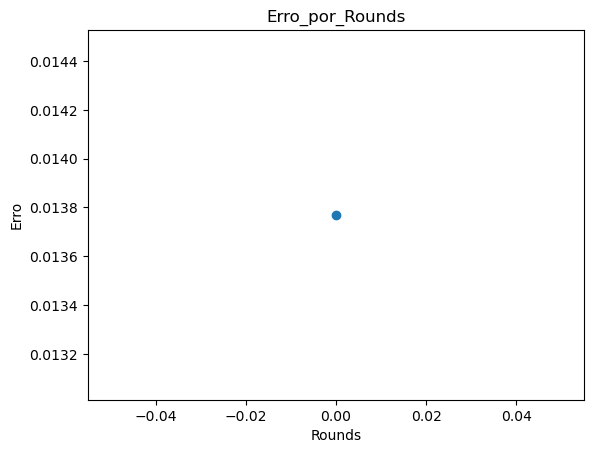

In [9]:
fig, ax = plt.subplots()
ax.scatter(xgb_cv.index.values.astype(int),
           xgb_cv['test-error-mean'])
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Rounds')
ax.set_ylabel('Erro')
ax.set_title('Erro_por_Rounds')
plt.show();

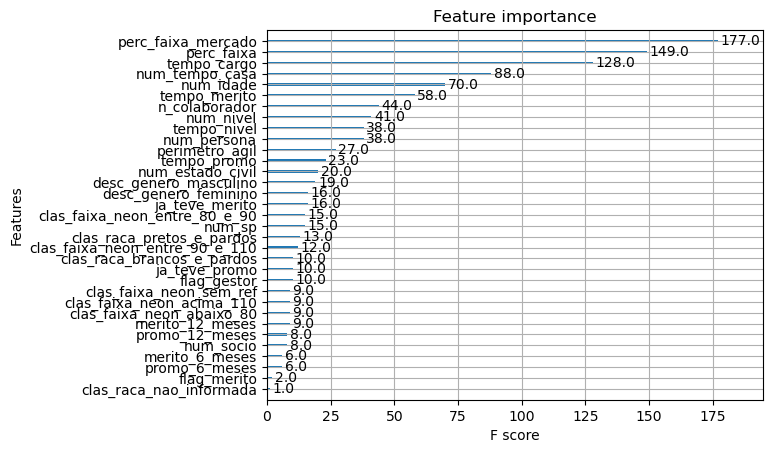

In [10]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

## Coleta aprendizados e aplica um modelo bom

In [11]:
# Prepara os dados para o modelo
X_original = X
lista_var = ['perc_faixa_mercado','perc_faixa','num_idade',
                'tempo_cargo','n_colaborador','num_persona',
                'num_tempo_casa','num_socio','num_nivel', 'ja_teve_promo', 'ja_teve_merito']
X = X_original[lista_var]
# Converte tabela para data_dmatrix (formato de dado otimizado para o xgboost)
data_dmatrix = xgb.DMatrix(data=X,label=y)
# Quebra os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Construção de modelo simples
params = {
            'objective':'binary:logistic',
            'learning_rate': 1.0,   # Ajuda a prevenir overfitting
            'max_depth': 4,         # Profundidade maxima por arvore
            'subsample':1,          # % de amostras por arvore
            'colsample_bytree':0.3, # % de cats por arvore
            'n_estimators':100,      # num de arvores
            'seed':42               # manter reprodutibilidade
        }
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)
# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
# Faz previsao no conjunto de teste
y_pred = xgb_clf.predict(X_test)

# Mede score de acuracia
from sklearn.metrics import accuracy_score
print('XGBoost model accuracy score: {0:0.2f}'. format(
    accuracy_score(y_test, y_pred)))


XGBoost model accuracy score: 0.99


In [12]:
from sklearn.metrics import confusion_matrix

#print(confusion_matrix(y_test, xgb_clf.predict(X_test)))

cm = confusion_matrix(y_test, xgb_clf.predict(X_test))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
  
print(cm)
print('Model Testing Accuracy = "{0:0.2f}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print()

[[6869   14]
 [  83    6]]
Model Testing Accuracy = "0.99!"



In [13]:
print(classification_report(y_test, xgb_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6883
           1       0.30      0.07      0.11        89

    accuracy                           0.99      6972
   macro avg       0.64      0.53      0.55      6972
weighted avg       0.98      0.99      0.98      6972



In [14]:
# make sure the SHAP values add up to marginal predictions
pred = xgb_clf.predict(X, output_margin=True)
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

1.04904175e-05

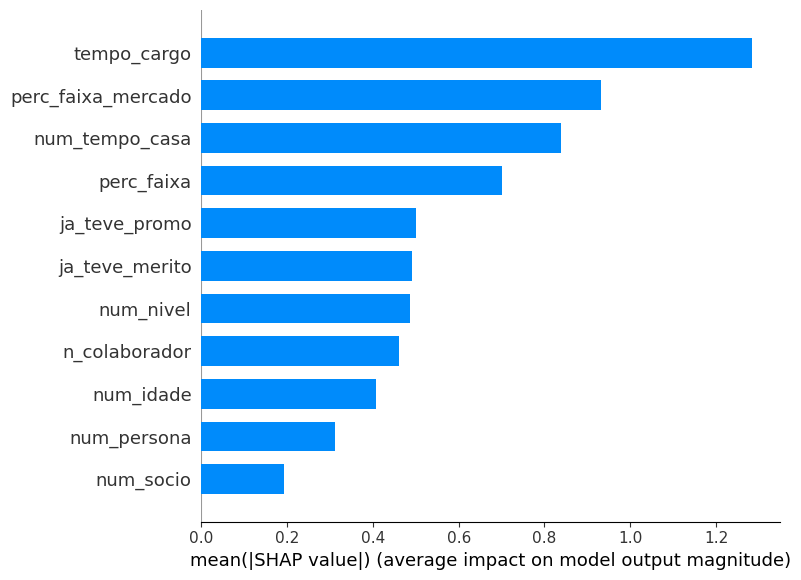

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar")


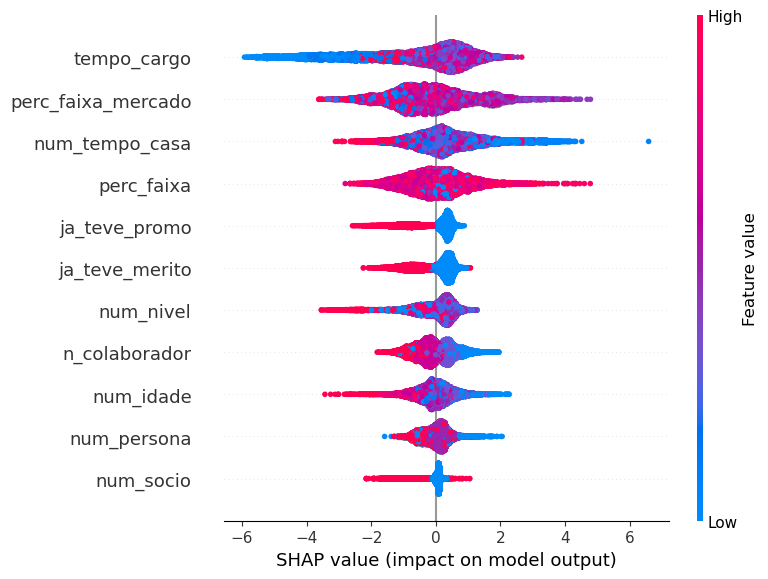

In [16]:
shap.summary_plot(shap_values, X)

In [17]:
# Monta tabela para comparaçã ode resultados
status = pd.DataFrame(y_test.reset_index(drop=True))
status.rename({'Status': 'status'}, axis=1, inplace=True)
pred = pd.DataFrame(y_pred.tolist(), columns =['pred'])
status['pred'] = pred

status.to_excel(r'status.xlsx', index = False)

status#.T

,status,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
6967,0,0
6968,0,0
6969,0,0
6970,0,0


In [18]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(
X_train.values,
feature_names=X_train.columns.values.tolist(),
class_names=['Status'],
categorical_features=categorical_features,
verbose=True, mode='regression')

In [ ]:
expXGB = explainer.explain_instance(
X_test.values[2],
xgb_clf.predict, num_features=9)
expXGB.show_in_notebook(show_table=True)